In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install  transformers

Note: you may need to restart the kernel to use updated packages.


#Convert wordst to Tokens

In [4]:
pip show torch

Name: torch
Version: 2.7.1+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\users\tanap\appdata\local\programs\python\python310\lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, sentence-transformers, torchaudio, torchvision
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
print("PyTorch version:", torch.__version__)# เวอร์ชัน PyTorch
print("CUDA available:", torch.cuda.is_available())# ใช้ GPU ได้ไหม
print("CUDA version:", torch.version.cuda)# เวอร์ชัน CUDA ที่ PyTorch ใช้
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")# ชื่อ GPU (ถ้ามี)

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce GTX 1050 Ti


**Load Library**

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from scipy.special import softmax

c:\Users\tanap\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0928 01:38:05.486117 32524 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


**Load dataset**

In [ ]:
DATA_PATH = "C:/Users/tanap/OneDrive/Desktop/Project_ML/datasets/intent_clean_full_NUMBER.csv"
df = pd.read_csv(DATA_PATH)

**ตรวจสอบ column**


In [ ]:
print("Columns:", df.columns.tolist())
texts = df["instruction"].astype(str).tolist()
labels = df["intent"].astype(str).tolist()

Columns: ['instruction', 'intent', 'instruction_tagged', 'tokens', 'tokens_str']


**Encode labels**

In [ ]:
le = LabelEncoder()
y = le.fit_transform(labels)

**BERT embeddings**

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
print("Encoding sentences with BERT embeddings...")
X = model.encode(texts, batch_size=32, show_progress_bar=True)

Encoding sentences with BERT embeddings...


Batches: 100%|██████████| 840/840 [00:13<00:00, 62.88it/s]


**Train/Test split**

In [ ]:
X_train, X_test, y_train, y_test, texts_train, texts_test = train_test_split(
    X, y, texts, test_size=0.2, random_state=42, stratify=y
)

**Train SVM + CalibratedClassifierCV**

In [ ]:
base_svm = LinearSVC(class_weight="balanced", max_iter=5000)
svm = CalibratedClassifierCV(base_svm, cv=3)

param_grid = {"estimator__C": [0.1, 1, 10, 50]}
grid = GridSearchCV(svm, param_grid, cv=3, scoring="f1_weighted", n_jobs=1, verbose=2)
print("Grid searching best C for LinearSVC...")
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)

Grid searching best C for LinearSVC...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...................................estimator__C=0.1; total time=  18.2s
[CV] END ...................................estimator__C=0.1; total time=  17.4s
[CV] END ...................................estimator__C=0.1; total time=  16.1s
[CV] END .....................................estimator__C=1; total time=  15.4s
[CV] END .....................................estimator__C=1; total time=  17.0s
[CV] END .....................................estimator__C=1; total time=  15.7s
[CV] END ....................................estimator__C=10; total time=  19.6s
[CV] END ....................................estimator__C=10; total time=  20.5s
[CV] END ....................................estimator__C=10; total time=  17.0s
[CV] END ....................................estimator__C=50; total time=  21.9s
[CV] END ....................................estimator__C=50; total time=  22.2s
[CV] END .

**Evaluate model**

In [9]:
y_test_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

print("\n=== Classification Report (Test set) ===")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


=== Classification Report (Test set) ===
                          precision    recall  f1-score   support

            cancel_order       0.99      0.99      0.99       200
            change_order       0.99      1.00      0.99       199
 change_shipping_address       0.98      0.99      0.99       195
  check_cancellation_fee       1.00      1.00      1.00       190
           check_invoice       1.00      1.00      1.00       200
   check_payment_methods       1.00      1.00      1.00       200
     check_refund_policy       1.00      0.99      0.99       199
               complaint       1.00      1.00      1.00       200
contact_customer_service       1.00      1.00      1.00       200
     contact_human_agent       1.00      1.00      1.00       200
          create_account       0.99      0.99      0.99       199
          delete_account       1.00      1.00      1.00       199
        delivery_options       1.00      1.00      1.00       199
         delivery_period       0.

**Check low-confidence predictions**

In [13]:
threshold = 0.5
low_conf_idx = np.where(y_proba.max(axis=1) < threshold)[0]

print(f"\nTotal low-confidence predictions (<{threshold}): {len(low_conf_idx)}/{len(y_test)}\n")

for idx in low_conf_idx:
    text = texts_test[idx]
    true_label = le.inverse_transform([y_test[idx]])[0]
    pred_label = le.inverse_transform([y_test_pred[idx]])[0]
    confidence = y_proba[idx].max()
    print(f"Text: {text}")
    print(f"  True Intent: {true_label}")
    print(f"  Predicted Intent: {pred_label}")
    print(f"  Confidence: {confidence:.3f}\n")



Total low-confidence predictions (<0.5): 8/5375

Text: where do i check ur goddamn money bafk guarantee
  True Intent: check_refund_policy
  Predicted Intent: get_refund
  Confidence: 0.419

Text: I am trying to find the shipping perod
  True Intent: delivery_period
  Predicted Intent: change_shipping_address
  Confidence: 0.458

Text: wanna call cystomer assistance
  True Intent: contact_customer_service
  Predicted Intent: contact_customer_service
  Confidence: 0.413

Text: can ya help me checking what methds for delivery ya offer
  True Intent: delivery_options
  Predicted Intent: delivery_options
  Confidence: 0.170

Text: get bill fromAnna Freeman
  True Intent: get_invoice
  Predicted Intent: get_refund
  Confidence: 0.468

Text: i do not know what to do to cdheck my bill #85632
  True Intent: check_invoice
  Predicted Intent: check_invoice
  Confidence: 0.476

Text: could ya help me locae purchase {{Order Number}}
  True Intent: track_order
  Predicted Intent: cancel_order
  Co

**Prediction function**

In [14]:
def predict_intent(text):
    emb = model.encode([text])
    pred = best_model.predict(emb)[0]
    return le.inverse_transform([pred])[0]

**Interactive loop**

In [18]:
while True:
    input_text = input("\nEnter your query (or type 'exit' to quit): ")
    if input_text.lower() == 'exit':
        break
    start = time.time()
    intent = predict_intent(input_text)
    elapsed = time.time() - start
    print(f"Input: {input_text}\n -> Predicted Intent: {intent}  (Runtime: {elapsed:.2f}s)")

**Plot confidence**

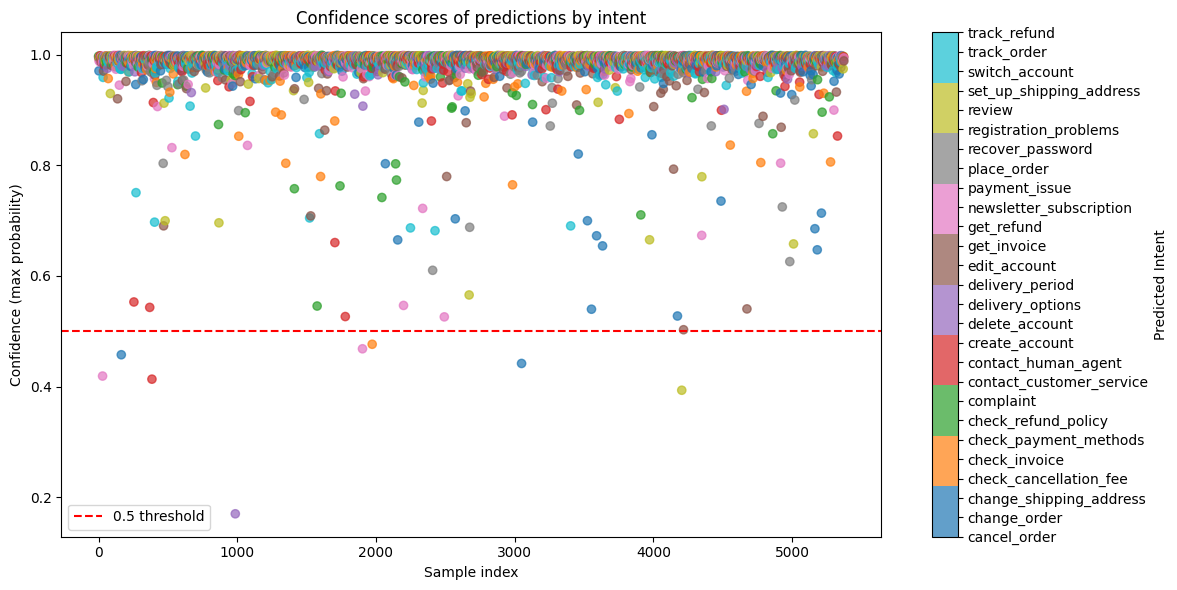

In [3]:
import matplotlib.pyplot as plt

# -------------------------------
# Plot confidence per intent
# -------------------------------
# ค่าความมั่นใจสูงสุดจาก predict_proba
confidences = probs.max(axis=1)
pred_labels = best_model.predict(X_test)
pred_intents = le.inverse_transform(pred_labels)

plt.figure(figsize=(12, 6))
scatter = plt.scatter(range(len(confidences)), confidences, 
                      c=pred_labels, cmap="tab10", alpha=0.7)

plt.axhline(0.5, color="red", linestyle="--", label="0.5 threshold")
plt.colorbar(scatter, ticks=range(len(le.classes_)), 
             label="Predicted Intent", 
             format=lambda x, _: le.classes_[int(x)])

plt.title("Confidence scores of predictions by intent")
plt.xlabel("Sample index")
plt.ylabel("Confidence (max probability)")
plt.legend()
plt.tight_layout()
plt.show()
